# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [36]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

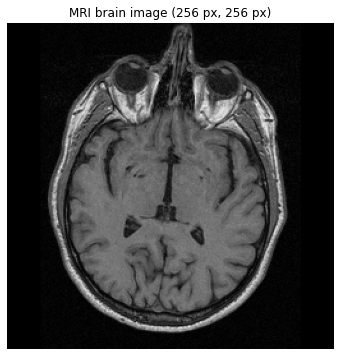

In [37]:
import skimage.io
from skimage import restoration
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.1bis Image Preprocessing

- show histogram (pre/post equalization)
- median filter
- sobel filter
- smooth (explain how it works)

Before diving into the segmentation of our brain image, it is always good practice to do some prepocessing. In the prepocessing we can try to remove noise using non-linear filters such as median filtering, wiener filter or non local mean filtering. We can also enhance the edges of the image using for example sobel filter. Another interesting aspect of the image is its histogram. Sometimes if we are interested in region with similar pixel values, it can be useful to do a histogram equalization to try to make clearer distinction between these regions.

#### Helpers

In [38]:
import cv2
def median_filter(img,k=3):
    new_image = np.zeros(img.shape,dtype=np.uint8)
    offset = int((k-1)/2)
    for i in range(offset,img.shape[0]-offset):
        for j in range(offset,img.shape[1]-offset):
            new_image[i,j] = int(np.median(img[i-offset:i+offset+1,j-offset:j+offset+1]))
    return new_image

def sobel_filter(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    final = cv2.addWeighted(grad, 0.2, img, 0.8, 0)
    return final

def plot_images(img_1,img_2,title_1,title_2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(img_1, cmap='gray')
    ax[0].set_title(title_1+'({} px, {} px)'.format(img_1.shape[0], img_1.shape[1]))
    ax[0].axis('off')
    ax[1].imshow(img_2, cmap='gray')
    ax[1].set_title(title_2+'({} px, {} px)'.format(img_2.shape[0], img_2.shape[1]))
    ax[1].axis('off')
    plt.show()

#### Histogram Equalization

We will perform histogram equalization to see if we can have a clearer separation (in term of pixel values) between our object of interest, the brain tissues, and the bones. 

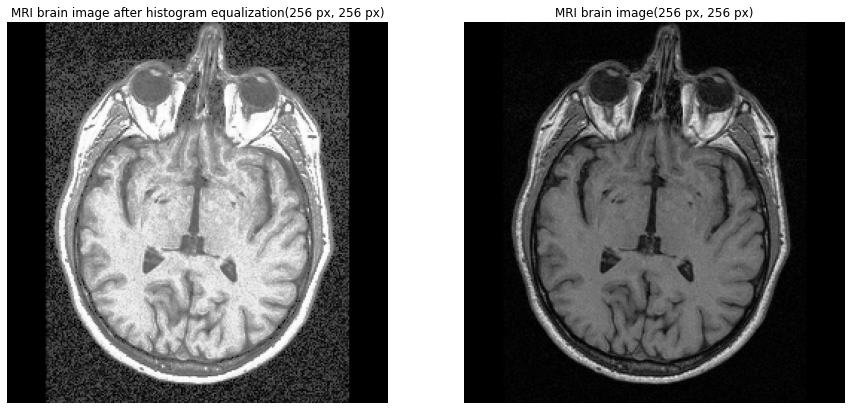

In [39]:
equalized_brain = cv2.equalizeHist(brain_im)
plot_images(equalized_brain,brain_im,"MRI brain image after histogram equalization","MRI brain image")

We can see that the histogram equalization was not really helpful to do the distinction brain/bone, but it allowed us to better see the noise in our image. First of all the noise is not uniformly spreaded in our image, we see that left and right borders are spared by the noise. We will crop the image in order to keep only a picture with some uniform noise in it.

In [40]:
brain_im = brain_im[:,30:-30] # Crop the black borders without noise

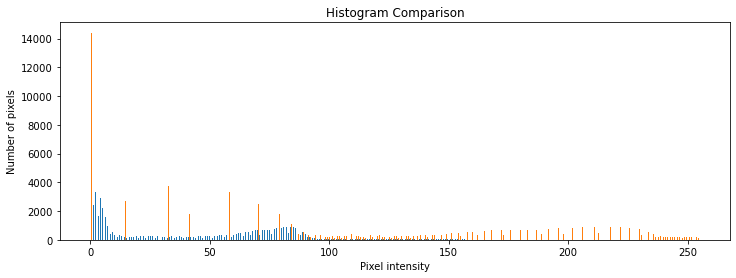

In [41]:
nb_bins = 256
# Display histogram
fig, ax = plt.subplots( figsize=(12, 4))
ax.hist([brain_im.ravel(),equalized_brain.ravel()], bins=nb_bins)
ax.set_title("Histogram Comparison")
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.show()

We can see the effect of the histogram equalization, we have a wider diversity of pixels, especially in the high values.

#### Noise removal

There exists several techniques to remove the noise. We tried three of them : 
- Median filtering
- Wiener filtering
- Non-local Means Denoising 

The **Median filter** works by replacing the value of a pixel by the median of its neighbours:

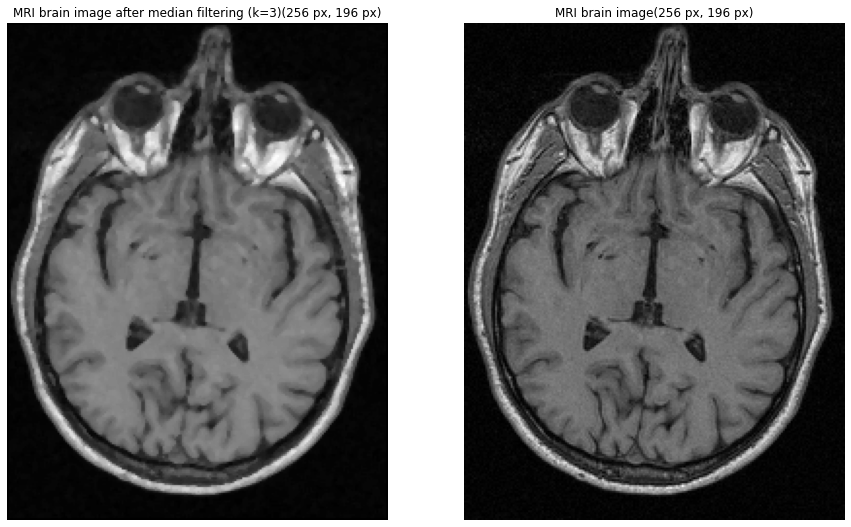

In [42]:
plot_images(median_filter(brain_im,k=3),brain_im,"MRI brain image after median filtering (k=3)","MRI brain image")

We can see that the filter has smoothed the image, which can be good in certain cases but also problematic in edge detection for example. Indeed we can see that the junction between the brain and the bone in the upper part of the image becomes really blury, which can be hard to segment afterward.

**Wiener Filter**

The idea behing the wiener filter is to reduce the frequency where the power of the noise is greater than the power of the image signal and to remove any effect of a system on the image. Here we assumed that the image was subject to no system but only to a noise. In the wiener filter we need to specify the location of the noise, which is done by taking the 4 corner of the image and concatening them. We do this to increase the range of values for the noise, and thus to get a better estimate of its power. But this method is suboptimal as by concatenating, we add some non linearity to our noise, artificially. In an ideal world, there would be a big portion of the image with only noise, but it is hard to find in such a small image.

In [71]:
concat_noise_up = np.concatenate([brain_im[:25,:25],brain_im[:25,-25:]],axis=1)
concat_noise_down = np.concatenate([brain_im[-25:,:25],brain_im[-25:,-25:]],axis=1)
concat_noise = np.concatenate([concat_noise_up,concat_noise_down],axis=0)

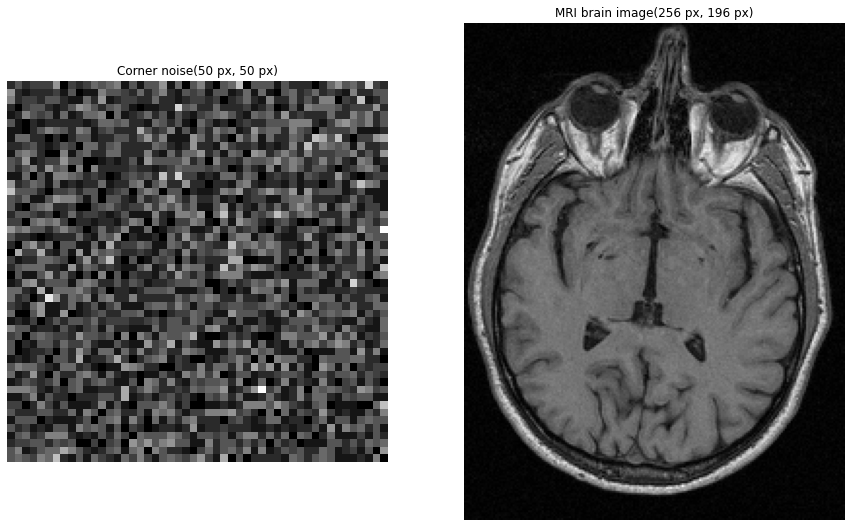

In [78]:
plot_images(concat_noise,brain_im,"Corner noise","MRI brain image")

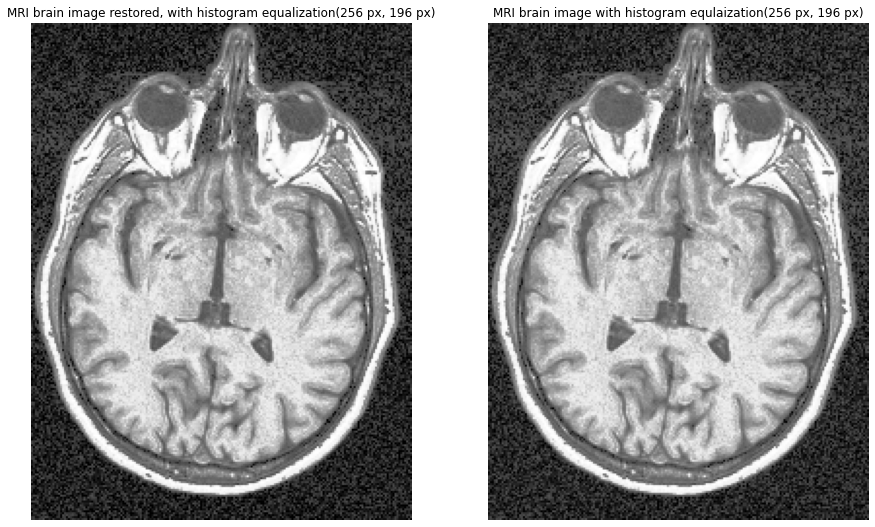

In [79]:
# https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node15.html

from scipy.signal import convolve2d as conv2
import scipy.fft
# Unaffected image
im = brain_im

# PSF filter
h_PSF = np.ones((1, 1))
#h_PSF = np.ones(1)
H_PSF = scipy.fft.fft2(h_PSF, s=im.shape)

im = conv2(im, h_PSF, 'same')
noise = concat_noise

# Spectras for autocorr
im_autocorr = scipy.signal.correlate2d(im, im,"same")
noise_autocorr = scipy.signal.correlate2d(noise, noise, "same")
im_autocorr_fft = scipy.fft.fft2(im_autocorr)
noise_autocorr_fft = scipy.fft.fft2(noise_autocorr, s=im.shape)
# Assembling wiener filter
H_wiener = np.conjugate(H_PSF)/(np.power(np.abs(H_PSF),2) + (noise_autocorr_fft/im_autocorr_fft))

# Restoring using wiener filter
im_fft = scipy.fft.fft2(im)
im_restored_fft = im_fft*H_wiener
im_restored = np.abs(scipy.fft.ifft2(im_restored_fft))
im_restored = im_restored.astype(np.uint8)

# Plot
plot_images(cv2.equalizeHist(im_restored),
                        cv2.equalizeHist(brain_im),"MRI brain image restored, with histogram equalization",
                        "MRI brain image with histogram equlaization")

We can see that we successfully removed some noise on the corner (the density of the noise is slightly less strong). But the result is not outstanding.

**Non Local Mean Denoising**

Non Local Mean Denoising is based on the assumption that the noise has zero mean. Thus if you take a small region in your image, by searching for other similar small region and doing their averages, you should get rid of the noise. This is implemented in OpenCV, and we use it based on the recommendation of: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html. 

In [81]:
smooth = cv2.fastNlMeansDenoising(im_restored,h=10,templateWindowSize=7,searchWindowSize=21)
plot_images(smooth, brain_im, "MRI brain image after Wiener filtering and NLMD","MRI brain image")

The result of the Non Local Mean Denoising is interesting because it has removed the small subtilities in the brain tissues, wich is good for our purpose of estimating its area. It can be problematic if we look for specific detail, but here it has more advantages for us.

#### Edge Enhancement

We can enhance the edges of an image by adding a small amount of the derivate of the image into it. We have to be careful when doing this because we can also increase the power of the noise. We used a sobel filter to compute the derivative of the image.

In [92]:
plot_images(sobel_filter(brain_im),brain_im,"MRI brain image added with a portion of its derivative","MRI brain image")

### 1.2 Region growing (5pts)

Region growing is a recursive segmentation method. You start from a seed (initial x,y coordinates) and then iteratively add to your object segmentation, all the neighbouring pixels that matches a certain threshold. The user must specify the seed and the threshold. We give two implementation, one based on recursivity (rec_grow) and the other is iterative (iterative_grow). Python is not a functional language, thus it is not optimized for recursivity, thus we prefer using the second implementation which is more "pythonic".

In [154]:
# Add your implementation and discussion
def rec_grow(img,x,y,l,tr):
    if img[x,y] > tr and (x,y) not in l:
        l.append((x,y))
        for p in neighbours(img,x,y):
            rec_grow(img,p[0],p[1],l,tr)
        
def neighbours(img,x,y):
    neighbours = []
    for i in range(-1,2):
        for j in range(-1,2):
            if not (i==0 and j==0):
                if in_image(img,x+i,y+j):
                    neighbours.append((x+i,y+j))
    return neighbours

def in_image(img,x,y):
    return x >= 0 and y >= 0 and x < img.shape[0] and y < img.shape[1]

def iterative_grow(img,x,y,tr):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] > tr and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

We give two different segmentation, one based on the smooth image and the other on only the post wiener filter one (im_reconstructed). The segmentation based on smooth is indeed more smooth, where as the second one is more precise. We will use the second one, with a bit of morphological closing on it to remove the very small hole, to estimate the area.

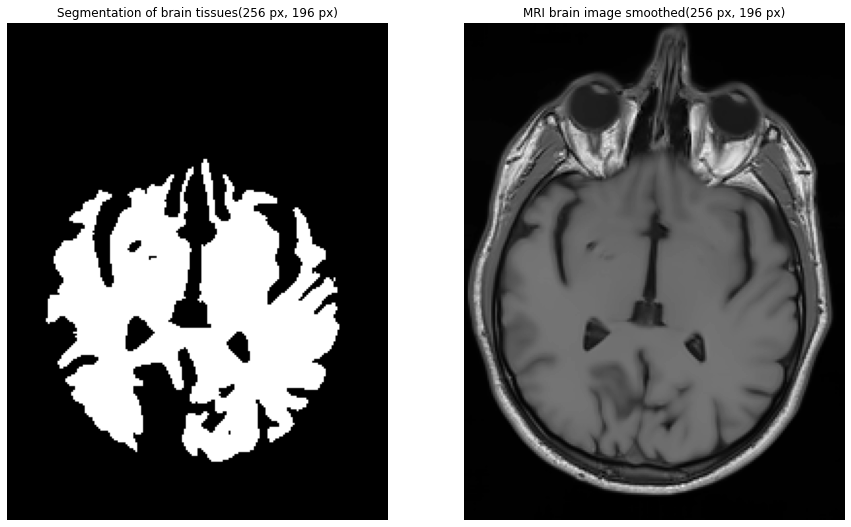

In [153]:
brain_segmentation = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(smooth,100,75,69):
    brain_segmentation[i[0],i[1]] = 255
plot_images(brain_segmentation,smooth,"Segmentation of brain tissues","MRI brain image smoothed")

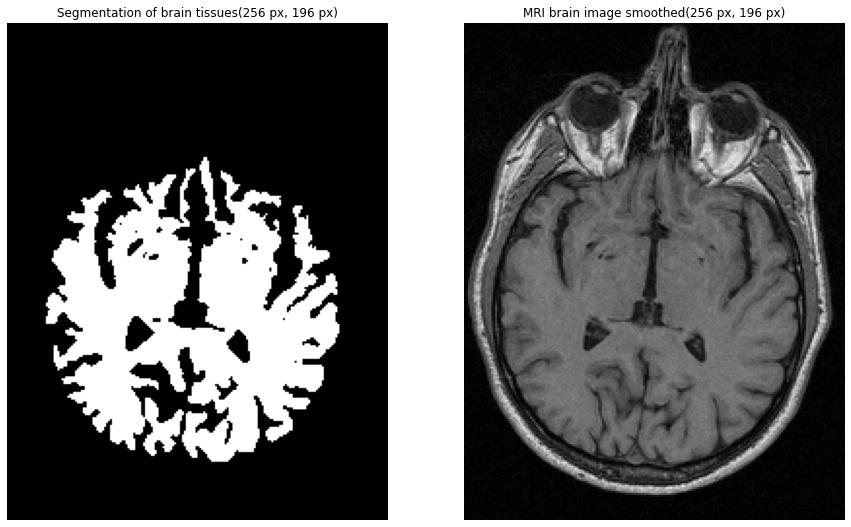

In [146]:
brain_segmentation = np.zeros(smooth.shape,dtype=np.uint8)
for i in iterative_grow(median_filter(im_restored),100,80,68):
    brain_segmentation[i[0],i[1]] = 255
plot_images(brain_segmentation,im_restored,"Segmentation of brain tissues","MRI brain image smoothed")

### 1.3 Contour detection (SMOOTH)(5pts)

In [19]:
def LoG(img,sigma=1,tr=150):
    gaussian = cv2.GaussianBlur(img,(0,0),sigma)
    log = cv2.Laplacian(gaussian, cv2.CV_64F)
    log = median_filter_alt(log,k=5)
    edge_mask = zero_crossing(log,tr)
    return edge_mask

def enhanced_contrast(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    a = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    b = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    enhanced = img + a - b
    return enhanced

In [24]:
def zero_crossing(img,tr=0):
    zero_crossing = np.zeros(img.shape,dtype=np.float32)
    max_diff = np.abs(img.max() - img.min())
    for i in range(1,img.shape[0]):
        for j in range(1,img.shape[1]):
            local_window = img[i-1:i+2,j-1:j+2]
            local_min = local_window.min()
            local_max = local_window.max()
            if local_min < 0 and local_max > 0 and (local_max - local_min  > tr) :
                zero_crossing[i,j] = 1
    return zero_crossing

def zero_crossing_2(img,tr=0):
    sign_shift_hor = np.zeros(img.shape,dtype=np.float32)
    sign_shift_ver = np.zeros(img.shape,dtype=np.float32)
    abs_diff_hor = np.zeros(img.shape,dtype=np.float32)
    abs_diff_ver = np.zeros(img.shape,dtype=np.float32)
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # Get sign shifts and combine
    sign_shift_hor[img > 0] = 1
    sign_shift_ver[img > 0] = 1
    
    sign_shift_hor[:,1:img_width] = np.abs(sign_shift_hor[:,1:img_width] - sign_shift_hor[:,0:img_width-1])
    sign_shift_ver[1:img_height,:] = np.abs(sign_shift_ver[1:img_height,:] - sign_shift_ver[0:img_height-1,:])
    
    sign_shift = sign_shift_hor + sign_shift_ver
    
    # Get absolute difference
    abs_diff_hor[:,1:img_width] = np.abs(img[:,1:img_width] - img[:,0:img_width-1])
    abs_diff_ver[1:img_height,:] = np.abs(img[1:img_height,:] - img[0:img_height-1,:])
        
    # Threshold the differences and combine
    abs_diff_hor[abs_diff_hor < tr] = 0
    abs_diff_hor[abs_diff_hor >= tr] = 1
    abs_diff_ver[abs_diff_ver < tr] = 0
    abs_diff_ver[abs_diff_ver >= tr] = 1
    
    abs_diff = abs_diff_hor + abs_diff_ver
    abs_diff[abs_diff > 0] = 1
    
    # Use sign shift mask and get final zero crossings
    abs_diff[sign_shift <= 0] = 0
    
    return abs_diff

# Test
gaussian = cv2.GaussianBlur(median_filter(brain_im,k=3),(0,0),0.1)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
test = zero_crossing_2(log,60)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(zero_crossing_2(log,60), cmap='gray')
ax.set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax.axis('off')

plt.show()

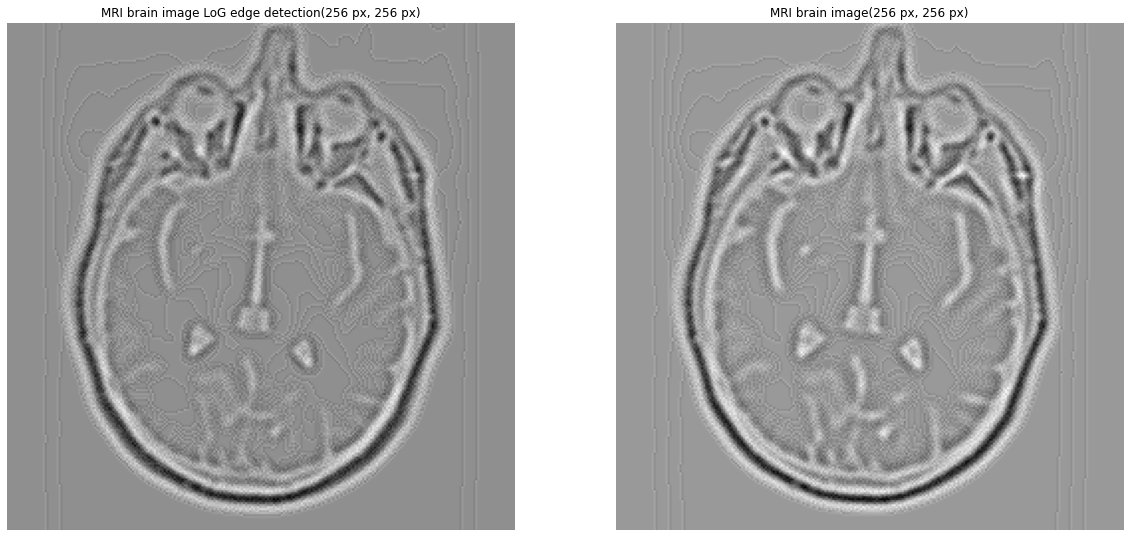

In [20]:
gaussian = cv2.GaussianBlur(sobel_filter(smooth),(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(log, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
gaussian = cv2.GaussianBlur(smooth,(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
ax[1].imshow(log, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

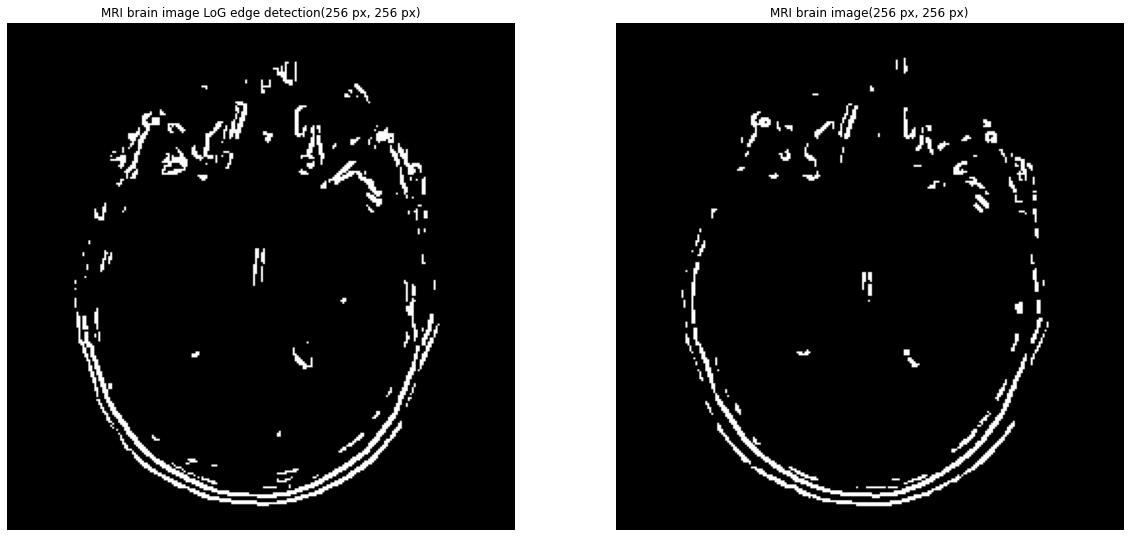

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(LoG(smooth,sigma=1,tr=10), cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(LoG(sobel_filter(smooth),sigma=1,tr=10), cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

### 1.3 Contour detection (5pts)

In [26]:
gaussian = cv2.GaussianBlur(median_filter(sobel_filter(brain_im),k=5),(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(log,"gray")
ax.set_title('LoG for brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(LoG(median_filter(brain_im,k=3),sigma=2,tr=0), cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(LoG(sobel_filter(median_filter(brain_im)),sigma=5,tr=0), cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

### 1.4 Additional method (5pts)

k-means

In [26]:
import k_means
%load_ext autoreload
%autoreload 2

In [27]:
compressed_brain_im = k_means.kmean_compression(smooth,k=4)

Current image: the shape of image=(65536, 1), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 429.14845275878906.
The current iteration of kmeans is: 10, the average loss is 113.66421770825558.
The current iteration of kmeans is: 20, the average loss is 57.8692578919953.


In [28]:
mask = compressed_brain_im == 76

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(compressed_brain_im, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

In [30]:
def aggregate(img,x,y,color):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] == color and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

In [31]:
brain_segmentation = np.zeros(compressed_brain_im.shape,dtype=np.int32)
for i in aggregate(compressed_brain_im,100,100,76):
    brain_segmentation[i[0],i[1]] = 255

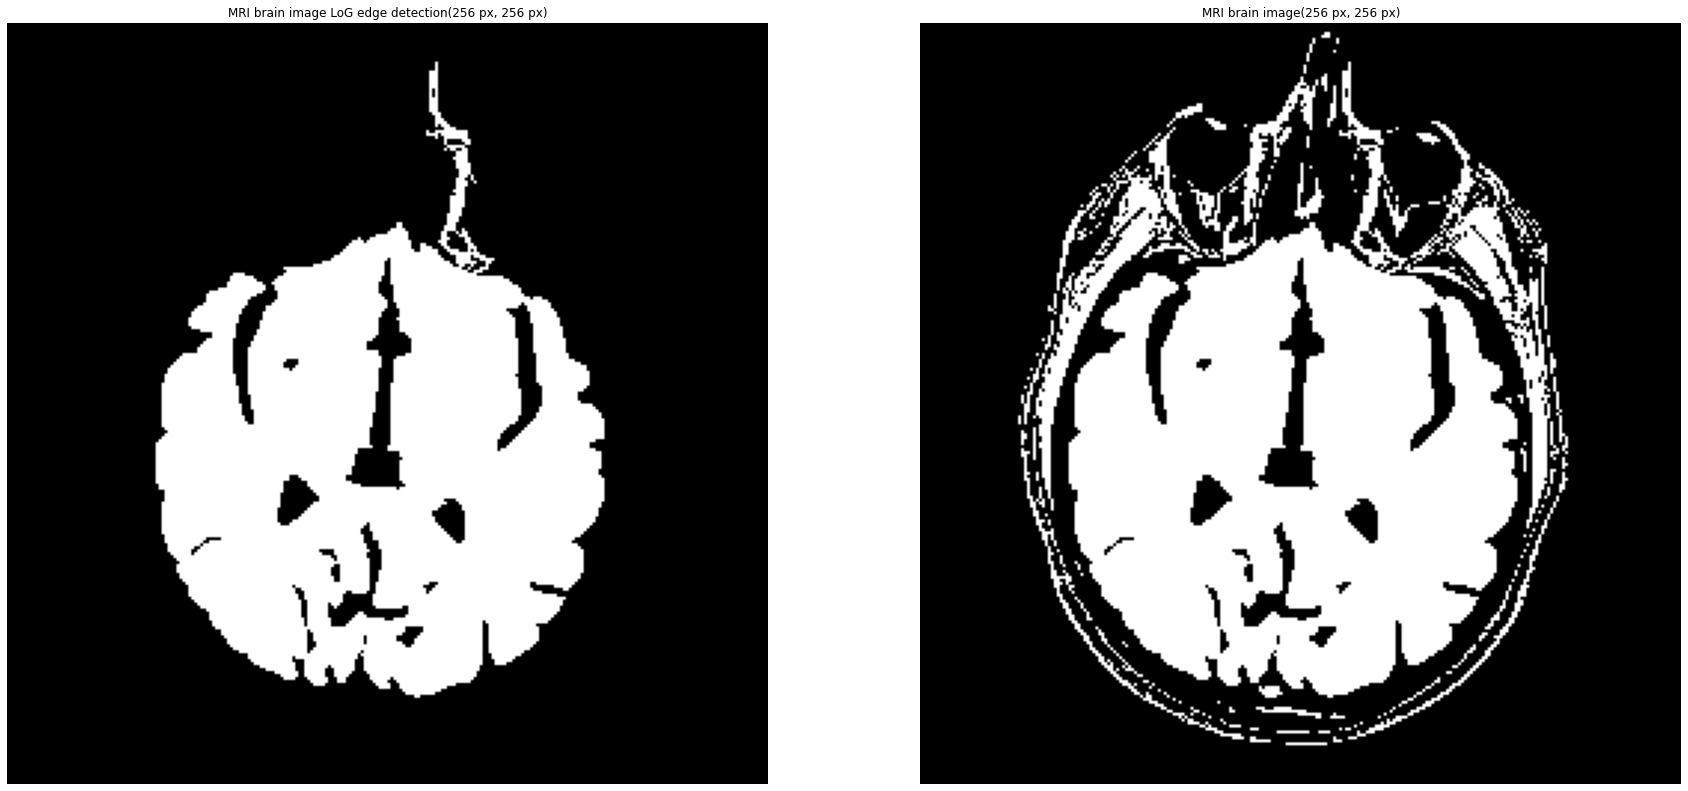

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(brain_segmentation, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

---

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion